In [1]:
import os, glob, sys
import matplotlib.pyplot as plt
import numpy as np
import h5py
import tensorflow as tf
%matplotlib inline
import skimage
from skimage.io import imread, imshow, imsave
from tensorflow.python.keras.models import *
from tensorflow.python.keras.layers import *
from tensorflow.python.keras.optimizers import *
from tensorflow.python.keras.callbacks import ModelCheckpoint, LearningRateScheduler
# from keras import backend as keras
import time
from eval import *
from ShowColors import *
from ImportUtil import *
%env CITYSCAPES_DATASET = /home/rvygon/data/

%load_ext autoreload
%autoreload 2

env: CITYSCAPES_DATASET=/home/rvygon/data/


In [2]:
#run this cell once
#%run  cityscapesscripts/preparation/createTrainIdLabelImgs
def upd_print(str):
            sys.stdout.write('\r')       
            sys.stdout.write(str)
            sys.stdout.flush()

In [3]:
img_shape = (256, 512, 3)
batch_size = 1
total_size = 10
val_size = 3
scale_rate = 4
verbose = 0
start_index = 0
import functools

In [4]:
x_train_data, y_train_data = importBatch(total_size, start_index, verbose,'train', scale_rate)
from tensorflow.python.keras.utils import to_categorical
y_train_data = to_categorical(y_train_data)
x_train_data = x_train_data.astype('uint8')
y_train_data = y_train_data.astype('uint8')

# TODO REWRITE IMPORT BATCH FOR VALIDATION DATA
x_val_data, y_val_data = importBatch(val_size, start_index, verbose, 'val', scale_rate)
y_val_data = to_categorical(y_val_data)
x_val_data = x_val_data.astype('uint8')
y_val_data = y_val_data.astype('uint8')
#x_val, y_val,files = importBatch(10,0,0,'val',scale = 4)
# from keras.utils import to_categorical

#y_val = to_categorical(y_val)

In [127]:
# import numpy as np
# import matplotlib.pyplot as plt
# # def IoU_metric(y_true, y_preds):
    
# def preprocess_pic(X, y):    
#     y=to_categorical(y)
#     return X, y

# def keras_generator(batch_size,scale):
#     while True:
#         batch_nums = np.random.randint(low=1000, high=2000, size=batch_size)
#         batch_input = []
#         batch_output = []
        
#         for index in batch_nums:
#             input_labels, input_images = getData(1, index,type='train')
#             input_image = input_images[0]
#             input_label = input_labels[0]           
            
#             X_img = imread(input_image)
#             if (scale != 0):
#                 X_new = np.zeros((int(X_img.shape[0] / scale), int(X_img.shape[1] / scale),3))
#                 k = 0
#                 for x in X_img[::scale]:
#                     X_new[k]=x[::scale]
#                     k+=1
#                 X_img = X_new
#             y_img = imread(input_label)
#             if (scale != 0):
#                 y_new = np.zeros((int(y_img.shape[0] / scale), int(y_img.shape[1] / scale)))
#                 k = 0
#                 for y in y_img[::scale]:
#                     y_new[k] = y[::scale]
#                     k += 1
#                 y_img = y_new
            
#             X_img, y_img = preprocess_pic(X_img, y_img)
            
#             batch_input.append(X_img)
#             batch_output.append(y_img)
            
#         batch_x = np.array(batch_input)
#         batch_y = np.array(batch_output)        
#         yield batch_x, batch_y
        

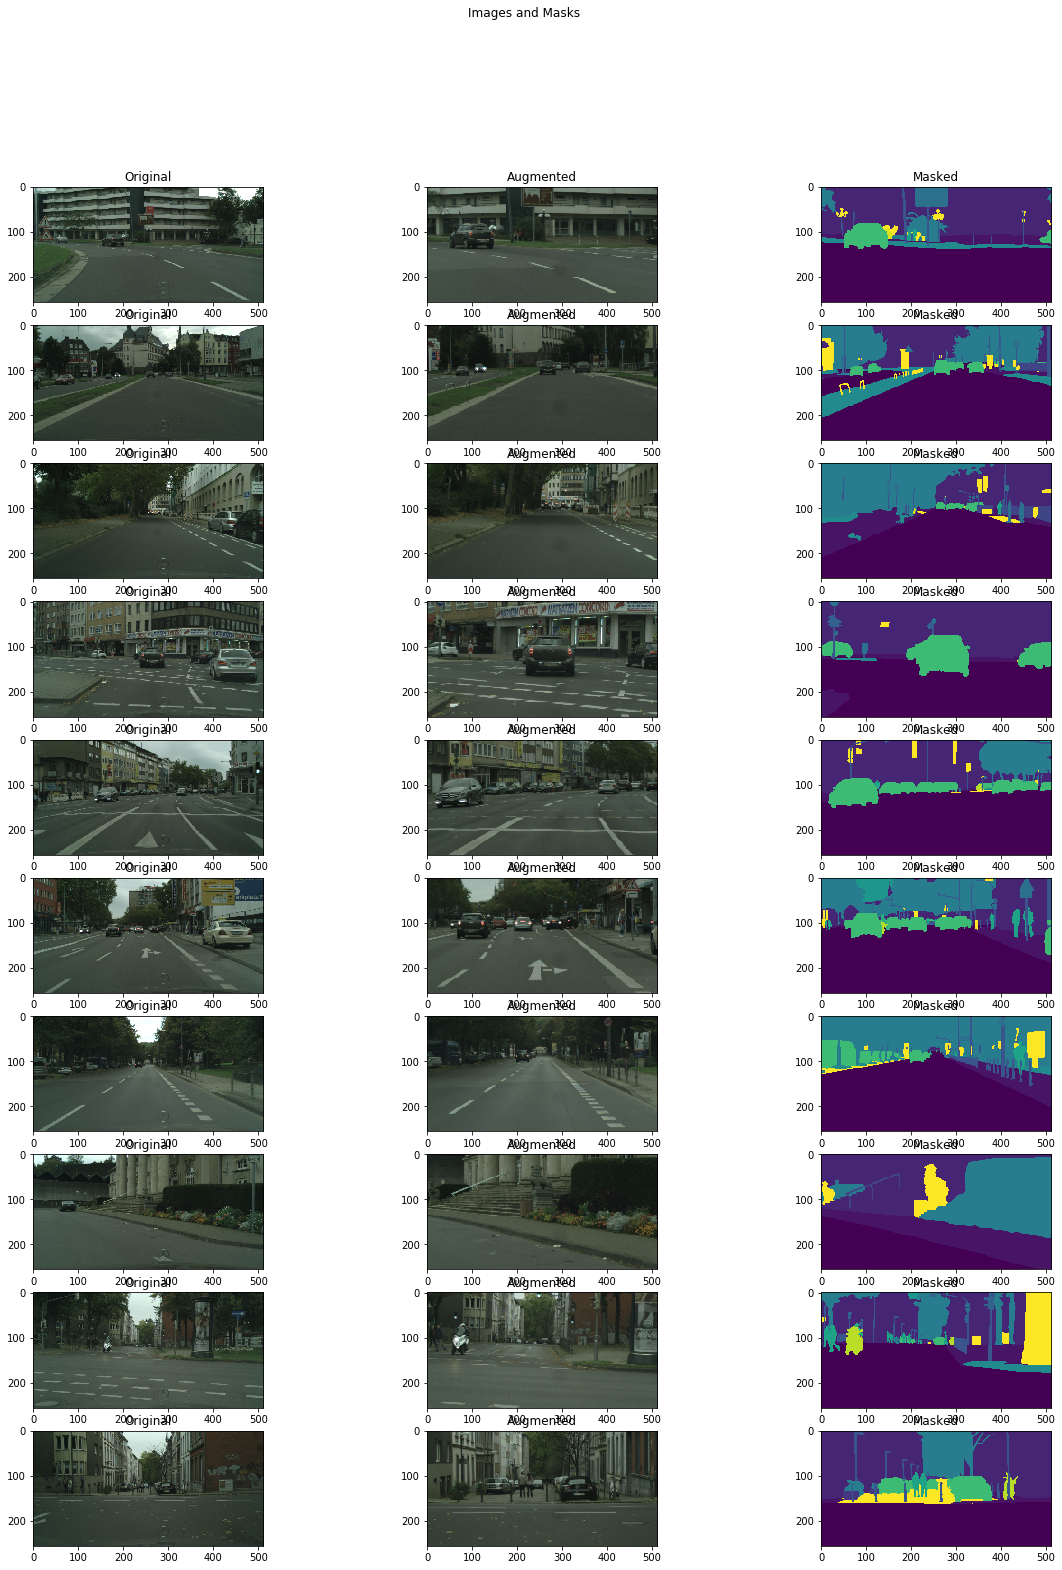

In [13]:
#visualize
num = 10
# chosed = np.random.choice(len(x_train_data), num)
chosed = range(10)
plt.figure(figsize=(20, 25))
for i in range(0, num * 3, 3):
    img_num = chosed[i // 3]
    x = x_train_data[img_num]
    y = y_train_data[img_num]
    sess = tf.Session()
    with sess.as_default():
        plt.subplot(num, 3, i + 1)
        plt.imshow(x)
        plt.title("Original")
        img, label = crop_img(0.5, x, y)
        x = img.eval()
        y = label.eval()
        plt.subplot(num, 3, i + 2)
        plt.imshow(x)
        plt.title("Augmented")
    
        y = np.argmax(y, axis=2)
        plt.subplot(num, 3, i + 3)
        plt.imshow(y)
        plt.title("Masked")

plt.suptitle("Images and Masks")
plt.show()

In [6]:
#UNET https://github.com/zhixuhao/unet/blob/master/model.py
def unet(pretrained_weights=None, input_size=img_shape):
    inputs = Input(input_size)
  
    conv1 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)    
    conv1 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))#drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(16, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(8, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    #conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(20, 1, activation = 'sigmoid')(conv9)

    model = Model([inputs], [conv10])

    model.compile(optimizer = Adam(lr = 1e-4), loss = 'categorical_crossentropy', metrics = ['accuracy'])

    if(pretrained_weights):
        model.load_weights(pretrained_weights)

    return model

In [7]:
def shifted_image(image, label, width_shift_range, height_shift_range):
    """horisontal or vertical shift"""
    if width_shift_range or height_shift_range:
        if width_shift_range:
            width_shift_range = tf.random_uniform([], -width_shift_range * img_shape[1], width_shift_range * img_shape[1])
        if height_shift_range:
            height_shift_range = tf.random_uniform([], -height_shift_range * img_shape[0], height_shift_range * img_shape[0])
        image = tf.contrib.image.translate(image, [width_shift_range, height_shift_range])
        label = tf.contrib.image.translate(label, [width_shift_range, height_shift_range])
    return image, label
            

In [8]:
def flip_img(horizontal_flip, image, label):
    if horizontal_flip:
        flip_prob = tf.random_uniform([], 0.0, 1.0)
        image, label = tf.cond(tf.less(flip_prob, 0.5),
                                   lambda: (tf.image.flip_left_right(image), tf.image.flip_left_right(label)),
                                   lambda: (image, label))
    return image, label

In [54]:
# def upscale_img(img, scale, dims):
#     if dims:
#         new_img = tf.zeros((img.shape[0] * scale, img.shape[1] * scale, 3))
#         for i in range(img.shape[0]):
#             for j in range(img.shape[1]):
#                 new_img[i * scale:(i + 1) * scale, j * scale:(j + 1) * scale, :] = img[i, j, :]
#     else:
#         new_img = np.zeros((img.shape[0] * scale, img.shape[1] * scale))
#         for i in range(img.shape[0]):
#             for j in range(img.shape[1]):
#                 new_img[i * scale:(i + 1) * scale, j * scale:(j + 1) * scale] = img[i, j]
#     return new_img

In [9]:
def crop_img(crop_rate, image, label):
    if crop_rate is not None:
        image = tf.image.resize_images(tf.image.central_crop(image, crop_rate), (img_shape[0], img_shape[1]), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
        label = tf.image.resize_images(tf.image.central_crop(label, crop_rate), (img_shape[0], img_shape[1]), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return image, label

In [10]:
def _augment(image,
             label,
             hue_delta=0,
             horisontal_flip=False,
             width_shift_range=0,
             height_shift_range=0,
             crop_rate=None):
    if hue_delta:
        image = tf.image.random_hue(image, hue_delta)
    image, label = flip_img(horisontal_flip, image, label)
    image, label = shifted_image(image, label, width_shift_range, height_shift_range)
    image, label = crop_img(crop_rate, image, label)
    return image, label

In [11]:
def to_tensor(image, label):
    return image, label

In [12]:
def get_dataset(images, labels,
                preproc_fn=functools.partial(_augment),
                threads=5,
                batch_size=batch_size,
                shuffle=True):
    num_x = len(images)
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
#     dataset = dataset.map(to_tensor, num_parallel_calls=threads)
    dataset = dataset.map(preproc_fn)
#     if shuffle:
#         dataset = dataset.shuffle(num_x)
    
    dataset = dataset.repeat().batch(batch_size)
    return dataset

In [14]:
tr_cfg = {
    'hue_delta': 0.2,
    'horisontal_flip': True,
    'crop_rate' : 0.5
}
tr_preprocessing_fn = functools.partial(_augment, **tr_cfg)

In [15]:
val_cfg = {
}
val_preprocessing_fn = functools.partial(_augment, **val_cfg)

In [16]:
train_ds = get_dataset(x_train_data, 
                       y_train_data,
                       preproc_fn=tr_preprocessing_fn,
                       batch_size=batch_size)
val_ds = get_dataset(x_val_data,
                      y_val_data,
                      preproc_fn=val_preprocessing_fn,
                      batch_size=batch_size)


[[[ 36  46  30]
  [ 36  46  30]
  [ 41  48  36]
  ...
  [ 80 100  80]
  [ 77  96  82]
  [ 77  96  82]]

 [[ 36  46  30]
  [ 36  46  30]
  [ 41  48  36]
  ...
  [ 80 100  80]
  [ 77  96  82]
  [ 77  96  82]]

 [[ 41  47  38]
  [ 41  47  38]
  [ 47  56  46]
  ...
  [ 66  81  73]
  [ 65  76  58]
  [ 65  76  58]]

 ...

 [[ 66  78  71]
  [ 66  78  71]
  [ 67  77  70]
  ...
  [ 66  77  69]
  [ 63  74  67]
  [ 63  74  67]]

 [[ 67  78  70]
  [ 67  78  70]
  [ 67  78  70]
  ...
  [ 65  77  69]
  [ 65  77  68]
  [ 65  77  68]]

 [[ 67  78  70]
  [ 67  78  70]
  [ 67  78  70]
  ...
  [ 65  77  69]
  [ 65  77  68]
  [ 65  77  68]]]
[[8 8 8 ... 8 8 8]
 [8 8 8 ... 8 8 8]
 [8 8 8 ... 8 8 8]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


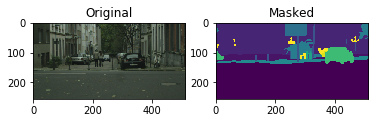

In [17]:
# TEST #

#WARNING ДАННЫЕ РАЗМЕЧЕНЫ НЕПРАВИЛЬНО

temp_ds = get_dataset(x_train_data,
                     y_train_data,
                     preproc_fn=tr_preprocessing_fn,
                     batch_size=1,
                     shuffle=False)
data_aug_iter = temp_ds.make_one_shot_iterator()
next_element = data_aug_iter.get_next()
for i in range(1):
    with tf.Session() as sess:
        batch_of_imgs, batch_of_labels = sess.run(next_element)
        img = batch_of_imgs[0]
        label = batch_of_labels[0]
        label = np.argmax(label, axis=2)
        print(img)
        print(label)
        plt.subplot(1, 2, 1)
        plt.imshow(x)
        plt.title("Original")
        plt.subplot(1, 2, 2)
        plt.imshow(label)
        plt.title("Masked")
        plt.show()

In [18]:
model = unet()
model_checkpoint = ModelCheckpoint('unet_tensorflow.hdf5', monitor='loss',verbose=1, save_best_only=True)
history = model.fit(train_ds, steps_per_epoch=10,epochs=8,callbacks=[model_checkpoint])#, validation_data=(x_val,y_val),validation_steps=20)

Instructions for updating:
`normal` is a deprecated alias for `truncated_normal`
Epoch 1/8
10/10 [==============================] - 4s 389ms/step - loss: 2.8391 - acc: 0.0522

Epoch 00001: loss improved from inf to 2.83912, saving model to unet_tensorflow.hdf5
Epoch 2/8
10/10 [==============================] - 0s 49ms/step - loss: 2.7238 - acc: 0.0700

Epoch 00002: loss improved from 2.83912 to 2.72382, saving model to unet_tensorflow.hdf5
Epoch 3/8
10/10 [==============================] - 1s 50ms/step - loss: 2.6747 - acc: 0.0921

Epoch 00003: loss improved from 2.72382 to 2.67466, saving model to unet_tensorflow.hdf5
Epoch 4/8
10/10 [==============================] - 0s 49ms/step - loss: 2.6376 - acc: 0.1107

Epoch 00004: loss improved from 2.67466 to 2.63758, saving model to unet_tensorflow.hdf5
Epoch 5/8
10/10 [==============================] - 1s 50ms/step - loss: 2.5993 - acc: 0.1459

Epoch 00005: loss improved from 2.63758 to 2.59933, saving model to unet_tensorflow.hdf5
Epoch 6

In [24]:
# model = unet()
# generator = keras_generator(1,4)
# model_checkpoint = ModelCheckpoint('unet_tensorflow.hdf5', monitor='loss',verbose=1, save_best_only=True)
# history = model.fit_generator(generator,steps_per_epoch=10,epochs=8,callbacks=[model_checkpoint])#, validation_data=(x_val,y_val),validation_steps=20)

Epoch 1/8
 9/10 [==========================>...] - ETA: 1s - loss: 6.4336 - acc: 0.0094
Epoch 00001: loss improved from inf to 6.35613, saving model to unet_tensorflow.hdf5
10/10 [==============================] - 15s 2s/step - loss: 6.3561 - acc: 0.0085
Epoch 2/8
 9/10 [==========================>...] - ETA: 0s - loss: 5.5650 - acc: 0.0031
Epoch 00002: loss improved from 6.35613 to 5.47992, saving model to unet_tensorflow.hdf5
10/10 [==============================] - 1s 136ms/step - loss: 5.4799 - acc: 0.0032
Epoch 3/8
 1/10 [==>...........................] - ETA: 0s - loss: 4.0569 - acc: 0.0238

KeyboardInterrupt: 

In [10]:
SCALE = 4
#tic = time.time()
#x_val, y_val, filenames = importBatch(500,0,0,'val',SCALE)
#toc = time.time()
#print('Load validation batch:', toc - tic)
def eval_model(model):          
        
        x_pred = model.predict(x_val,verbose=1)        
        new_x=np.argmax(x_pred,axis=3)
        
        """ UPSCALING
        new_new_x = np.zeros((new_x.shape[0],new_x.shape[1]*SCALE,new_x.shape[2]*SCALE))
        
        for i in range(x_pred.shape[0]):
            new_new_x[i]=UpscaleImg(new_x[i],SCALE,0)
            upd_print(("Upscaled %d images" % i))
        print()
        new_new_x=new_new_x.astype(int)"""
        
        new_x=new_x.astype(int)        
        
        """   SAVE
        cityscapesPath = os.environ['CITYSCAPES_DATASET']        
        for i in range(len(filenames)):
            impath = os.path.join(cityscapesPath,'results', filenames[i].split('/')[7]+'.png')           
            imsave(impath, new_new_x[i])
            upd_print("Saved %d images" % i)            
        print()
        toc = time.time()
        print('Save files:', toc -tic) """
        
        score = eval_preds(new_x,y_val)        
        return score

model = load_model('resnet.hdf5')
print(eval_model(model))

TypeError: tuple indices must be integers or slices, not list